In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import jacfwd, jacrev
import jax

#pictures from https://www.youtube.com/watch?v=0x0JD5uO_ZQ

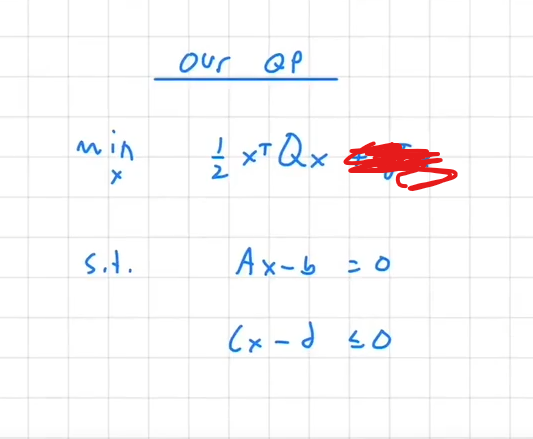

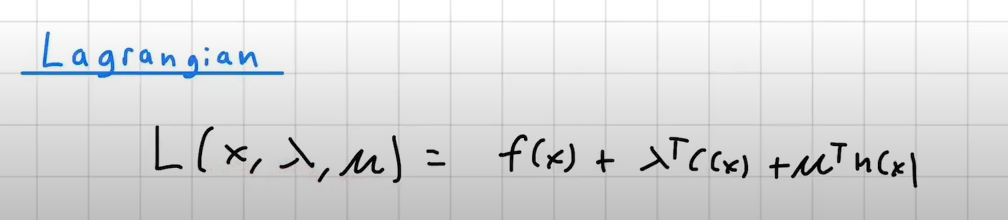

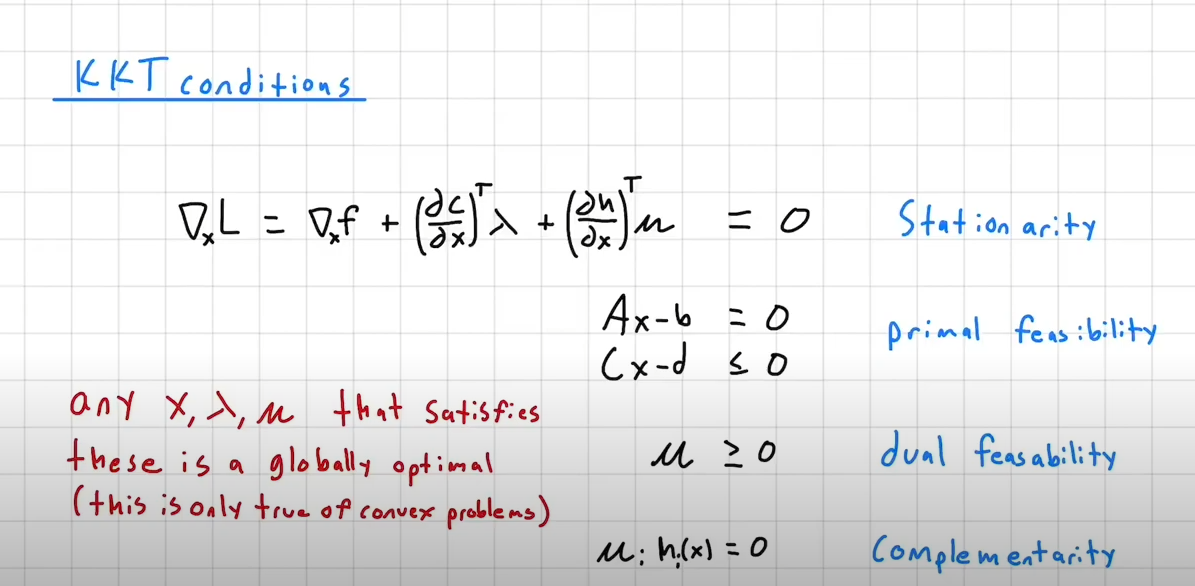

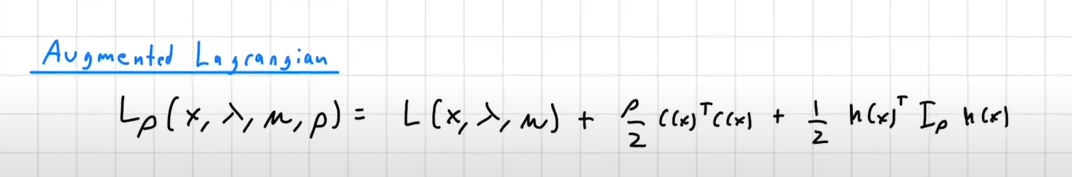

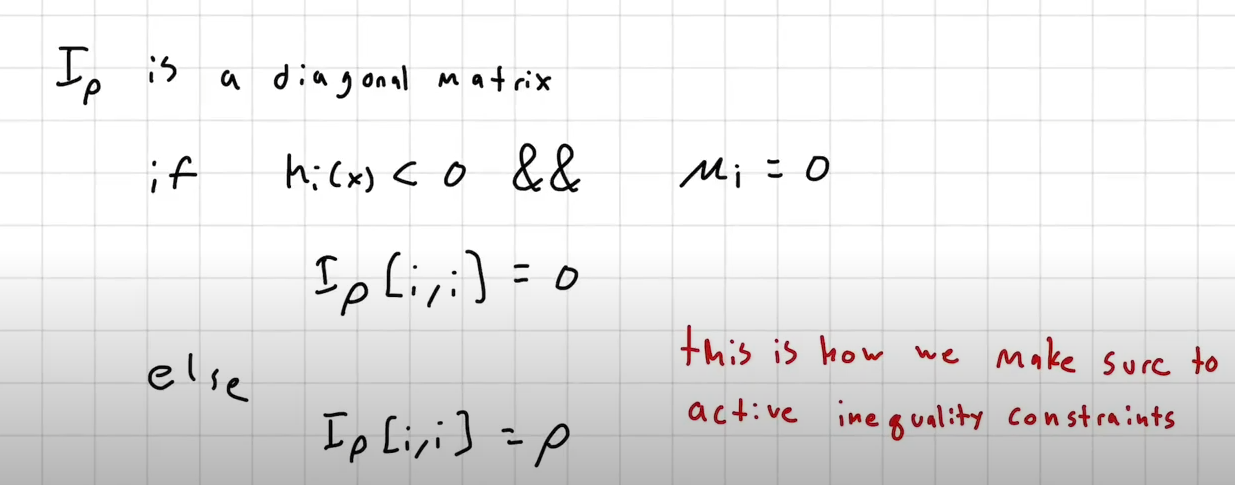

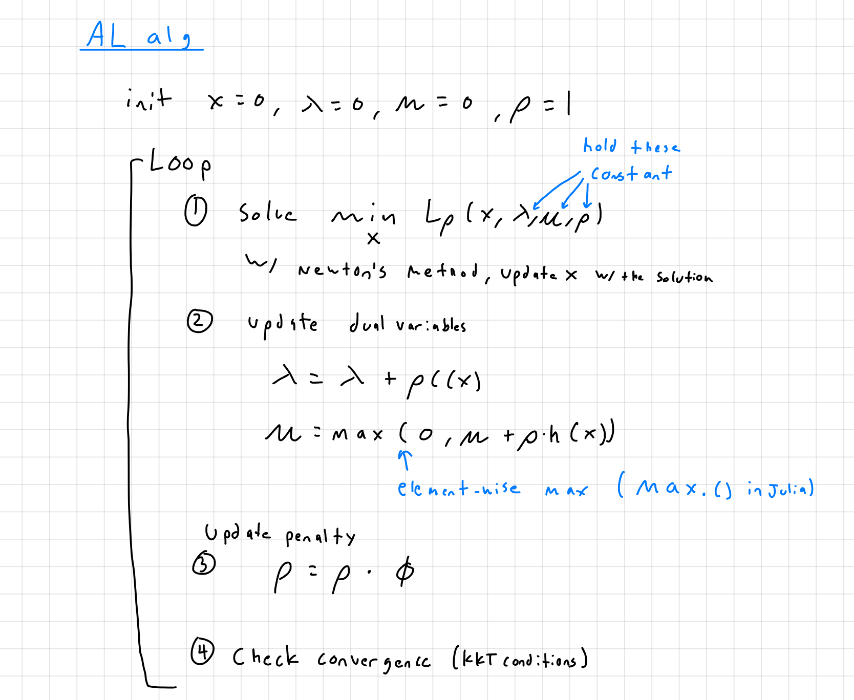

In [13]:
class QP:
  def __init__(self, u, x, A, B, Q, R, steps, uCon):
    self.steps = steps
    self.A = A
    self.B = B
    self.u = u
    self.x = x
    self.Q = Q
    self.R = R
    self.z = jnp.hstack((u, x)).reshape(-1, 1)
    self.H = jnp.zeros((self.z.shape[0], self.z.shape[0]), dtype=self.z.dtype).at[jnp.arange(self.z.shape[0]), jnp.arange(self.z.shape[0])].set(self.z.flatten())
    self.c = self.getC()
    self.d = self.getD()
    self.λ = jnp.zeros((1, int(self.steps * self.A.shape[0])), dtype="float32")
    self.μ = jnp.zeros((1, self.z.shape[0]), dtype="float32")
    self.p = 1
    self.e = self.getE()
    self.g = self.getG(uCon)
    self.eq = self.eqCon(self.z)
    self.ineq = self.ineqCon(self.z)
    self.Ip = self.updateIp(self.z)

  def updateIp(self, z):
    self.ineq = self.ineqCon(z)
    Ip = jnp.eye(z.shape[0])
    for i in range(Ip.shape[0]):
      if (self.μ[0][i] == 0 and self.ineq[i][0] < 0):
        Ip = Ip.at[i, i].set(0)
      else:
        Ip = Ip.at[i, i].set(self.p)
    return Ip

  def getC(self):
    I = -1*jnp.eye(x[0].shape[0])
    c = jnp.zeros((int(self.steps * self.A.shape[0]), self.z.shape[0]))
    c = c.at[0:self.B.shape[0], 0:self.B.shape[1]].set(self.B)
    c = c.at[0:B.shape[0], B.shape[1]:B.shape[1]+I.shape[1]].set(I)
    step = self.B.shape[1]
    for i in range(4, c.shape[0], 4):

      c = c.at[i:self.A.shape[0] + i, step : step  + self.A.shape[1]].set(self.A)
      c = c.at[i:self.B.shape[0] + i, step  + self.A.shape[1] : step  + self.A.shape[1] + self.B.shape[1]].set(self.B)
      c = c.at[i:I.shape[0] + i, step  + self.A.shape[1] + self.B.shape[1] : step  + self.A.shape[1] + self.B.shape[1] + I.shape[1]].set(I)

      step += self.A.shape[1] + self.B.shape[1]
    return c

  def getD(self):
    d = jnp.zeros((int(self.steps * self.A.shape[0]), 1), dtype=self.z.dtype)
    initial = -self.A@jnp.array([x[0]]).T
    d = d.at[0:initial.shape[0], 0:initial.shape[1]].set(initial)

    return d

  def cost(self, z):

    return .5*z.T@self.H@z

  def eqCon(self, z):
    #c@z = d
    return self.c@z - self.d

  def getE(self):
    e = jnp.eye(self.z.shape[0])
    for i in range(self.u.shape[1], self.z.shape[0], self.u.shape[1] + self.x.shape[1]):
      for j in range(self.x.shape[1]):
        e = e.at[i+j, i+j].set(0)

    return e

  def getG(self, uCon):
    g = jnp.zeros((self.z.shape[0], 1))
    for i in range(g.shape[0]):
      g = g.at[i, 0].set(uCon)
    return g

  def ineqCon(self, z):
    #e@(z*z) <= g
    return self.e@(z*z) - self.g

  def augmentedLagragianCost(self, z):
    self.eq = self.eqCon(z)
    self.ineq = self.ineqCon(z)
    self.Ip = self.updateIp(z)
    return (self.cost(z) + self.λ@self.eq + self.μ@self.ineq + self.p/2*self.eq.T@self.eq+ .5*self.ineq.T@self.Ip@self.ineq)[0][0]

  def lagragianCost(self, z):
    self.eq = self.eqCon(z)
    self.ineq = self.ineqCon(z)
    return (self.cost(z) + self.λ@self.eq + self.μ@self.ineq)[0][0]

  def lineSearch(self, deltaZ, jacobian):
    alpha = 1
    b = .1
    c = .5
    count = 0
    while (self.augmentedLagragianCost(self.z + deltaZ) > self.augmentedLagragianCost(self.z) + (b*alpha*jacobian.T@deltaZ)[0][0]):

      alpha *= c
      if count == 4:
        return alpha
      count += 1
    return alpha

  def augmentedLagragianSolver(self):
    for j in range(3):
      print(j)
      while (jnp.any(jacfwd(lambda z: self.augmentedLagragianCost(z))(self.z) > .001)):
        #regulaize and scaling the hessian to make it inveratable
        jacobian = jacfwd(lambda z: self.augmentedLagragianCost(z))(self.z)
        hessian = jacfwd(jacfwd(lambda z: self.augmentedLagragianCost(z)))(self.z).reshape(self.z.shape[0], self.z.shape[0])
        max_value = jnp.max(jnp.abs(hessian))
        hessian /= max_value
        hessian += 1e-5 * jnp.eye(hessian.shape[0])
        deltaZ = -1*(jnp.linalg.inv(hessian) / max_value)@jacobian
        #a = self.lineSearch(deltaZ, jacobian)
        self.z += deltaZ

      self.eq = self.eqCon(self.z)
      self.ineq = self.ineqCon(self.z)

      self.λ = self.λ + self.p*self.eq.T
      self.μ = jnp.maximum(jnp.zeros((1, self.z.shape[0])), self.μ + self.p*self.ineq.T)
      self.p = self.p * 10

  def checkConvergance(self): #kkt conditions
    self.eq = self.eqCon(self.z)
    self.ineq = self.ineqCon(self.z)
    return jnp.all(self.eq == 0) and jnp.all(self.ineq <= 0) and jnp.all(self.μ >= 0) and jnp.all(self.μ*self.ineq.T == 0) and jnp.all(jacfwd(lambda z: self.lagragianCost(z))(self.z) == 0)

  def getXfromZ(self):
    x = jnp.zeros(self.x.shape)
    count = 0
    for i in range(self.u.shape[1], self.z.shape[0], self.x.shape[1] + self.u.shape[1]):
      x = x.at[count: count + 1, 0: x.shape[1]].set(self.z[i: i + self.x.shape[1]][:].T)
      count += 1

    return x

  def getUfromZ(self):
    u = jnp.zeros(self.u.shape)
    count = 0
    for i in range(0, self.z.shape[0], self.x.shape[1] + self.u.shape[1]):
      u = u.at[count: count + 1, 0: u.shape[1]].set(self.z[i: i + self.u.shape[1]][:].T)
      count += 1

    return u






In [14]:
dt = .05

A = jnp.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, (1-dt), 0],
              [0, 0, 0, (1-dt)]], dtype="float32")
B = jnp.array([[0, 0],
              [0, 0],
              [200*dt, 0],
              [0, 200*dt]], dtype="float32")

R = jnp.eye(B.shape[0])

Q = jnp.eye(A.shape[0])

steps = 10
u = jnp.zeros((steps, 2), dtype="float32")
x = jnp.zeros((steps, 4), dtype="float32")
x = x.at[:, 0].set(5)
x = x.at[:, 1].set(5)



qpTest = QP(u, x, A, B, Q, R, steps , 10)

qpTest.augmentedLagragianSolver()
xtest = qpTest.getXfromZ()

utest = qpTest.getUfromZ()
print(xtest)
print(utest)
#print(A@xtest[0]+B@utest[1])
#print(xtest[1])




0
1
2
[[ 4.8080120e+00  4.8080120e+00 -3.1642675e+01 -3.1642675e+01]
 [ 3.1121819e+00  3.1121819e+00 -5.0978710e+01 -5.0978710e+01]
 [ 5.4997528e-01  5.4997528e-01 -1.6804531e+01 -1.6804531e+01]
 [-2.7641430e-01 -2.7641433e-01  5.3487625e+00  5.3487635e+00]
 [-8.6607719e-03 -8.6607346e-03  2.6893327e-01  2.6893288e-01]
 [ 4.5958357e-03  4.5958539e-03 -9.4796702e-02 -9.4796717e-02]
 [-1.1882787e-04 -1.1881050e-04 -9.5664039e-03 -9.5668985e-03]
 [-5.7306432e-04 -5.7307101e-04  1.0021908e-02  1.0022025e-02]
 [-7.4300064e-05 -7.4300566e-05  4.1208421e-03  4.1207159e-03]
 [ 1.2576743e-04  1.2576091e-04  3.7953007e-05  3.7944515e-05]]
[[-3.1636992e+00 -3.1636992e+00]
 [-2.0918171e+00 -2.0918169e+00]
 [ 3.1624539e+00  3.1624539e+00]
 [ 2.1313066e+00  2.1313066e+00]
 [-4.8123908e-01 -4.8123923e-01]
 [-3.5028338e-02 -3.5028305e-02]
 [ 8.0490457e-03  8.0489982e-03]
 [ 1.9110005e-03  1.9110589e-03]
 [-5.3999695e-04 -5.4002058e-04]
 [-3.8768494e-04 -3.8767385e-04]]


In [15]:
qpTest.checkConvergance()
print(qpTest.eq)


[[ 1.91987991e-01]
 [ 1.91987991e-01]
 [ 5.68389893e-03]
 [ 5.68389893e-03]
 [ 1.13696337e-01]
 [ 1.13696337e-01]
 [-3.81469727e-06]
 [ 0.00000000e+00]
 [ 1.32709742e-02]
 [ 1.32709742e-02]
 [-7.05718994e-04]
 [-7.05718994e-04]
 [-1.38370395e-02]
 [-1.38369799e-02]
 [ 0.00000000e+00]
 [-9.53674316e-07]
 [-3.15389596e-04]
 [-3.15426849e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.90055929e-04]
 [ 1.90054998e-04]
 [-7.45058060e-08]
 [-1.19209290e-07]
 [-2.51718302e-05]
 [-2.51715028e-05]
 [-7.45058060e-09]
 [-7.45058060e-09]
 [-2.40837398e-05]
 [-2.40844383e-05]
 [ 1.39698386e-08]
 [ 1.02445483e-08]
 [ 2.33118044e-06]
 [ 2.33080937e-06]
 [ 1.39698386e-09]
 [ 1.86264515e-09]
 [ 5.97460894e-06]
 [ 5.97431790e-06]
 [-2.31011654e-09]
 [-3.13229975e-09]]


#test with just ints

In [ ]:

x = jnp.array(0, dtype=jnp.float32)
λ = 0
μ = 0
p = 1
def cost(x):
  return x**2
def eqCon(x): #x=-3
  return x + 17
def ineqCon(x): #x<-1
  return x +10
ineq = ineqCon(x)
eq = eqCon(x)

def augmentedLagragian(x, λ, μ, p):
  ineq = ineqCon(x)
  eq = eqCon(x)
  I = jnp.eye(1)

  for i in range(I.shape[0]):
    if (ineq < 0 and μ == 0):
      I = I.at[i ,i].set(0)
    else:

      I = I.at[i ,i].set(p)
  return (cost(x) + λ*eq + μ*ineq + p/2*eq*eq + 1/2 * ineq*I*ineq)[0][0]

augmentedLagragian_grad_x = grad(lambda x: augmentedLagragian(x, λ, μ, p))
augmentedLagragian_grad_grad_x = grad(grad(lambda x: augmentedLagragian(x, λ, μ, p)))

def augmentedLagragianSolver(x, λ, μ, p):
  for j in range(10):
    while (grad(lambda x: augmentedLagragian(x, λ, μ, p))(x) > .01):
      x += -grad(lambda x: augmentedLagragian(x, λ, μ, p))(x)/grad(grad(lambda x: augmentedLagragian(x, λ, μ, p)))(x)
    λ = λ + p*eq
    μ = jnp.maximum(0, μ + p*ineq)
    p = p * 10

augmentedLagragianSolver(x, λ, μ, p)


-6.75
434.5625
-13.5
4461.25
-14.836634
43399.125
-14.983517
432403.5
-14.99835
4322404.0
-14.999835
43222404.0
-14.999984
432222430.0


TypeError: Cannot interpret 'Array([[1.2722245e+08]], dtype=float32)' as a data type